### Оглавление
* [Задача проекта](#chapter1)
* [Шаг 1. Загрузка данных](#chapter2)
* [Шаг 2. Исследовательский анализ данных (EDA)](#chapter3)
* [Шаг 3. Модель прогнозирования оттока клиентов](#chapter4)
* [Шаг 4. Кластеризация клиентов, алгоритм K-Means](#chapter5)
* [Шаг 5. Выводы и рекомендации](#chapter6)

## Задача проекта <a class="anchor" id="chapter1"></a>
На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока для каждого клиента в следующем месяце, затем сформировать с помощью кластеризации портреты пользователей. Дать краткие рекомендации для сокращения оттока.

В данном проекте использовано машинное обучение. Спрогнозирована вероятность оттока (на уровне следующего месяца) для каждого клиента; сформированы типичные портреты пользователей: выделены наиболее яркие группы, охарактеризованы их основные свойства; проанализированы основные признаки, наиболее сильно влияющие на отток.

## Шаг 1. Загрузка данных <a class="anchor" id="chapter2"></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import sidetable
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv') # прочитаем данные
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

## Шаг 2. Исследовательский анализ данных (EDA) <a class="anchor" id="chapter3"></a>

Посмотрим на данные, и оценим количество пропусков, выбросов и категориальных признаков.\
Обычно предварительная обработка данных включает следующие этапы: \
Работа с пропущенными значениями\
Работа с выбросами\
Преобразование категориальных переменных\
Стандартизация данных в случае работы с линейными моделями или моделями, которые чувствительны к расстоянию (например, кластеризация)
Иногда к этому же этапу относят отбор признаков, но это можно делать и на более поздних стадиях разработки модели.

In [3]:
df.info() # выведем инфо, посмотрим на тип столбцов и наличие пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [4]:
df.describe() # изучим средние значения и стандартные отклонения 

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [5]:
# Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
display(df.groupby('Churn').mean().T) # транспонируем вывод для удобства

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


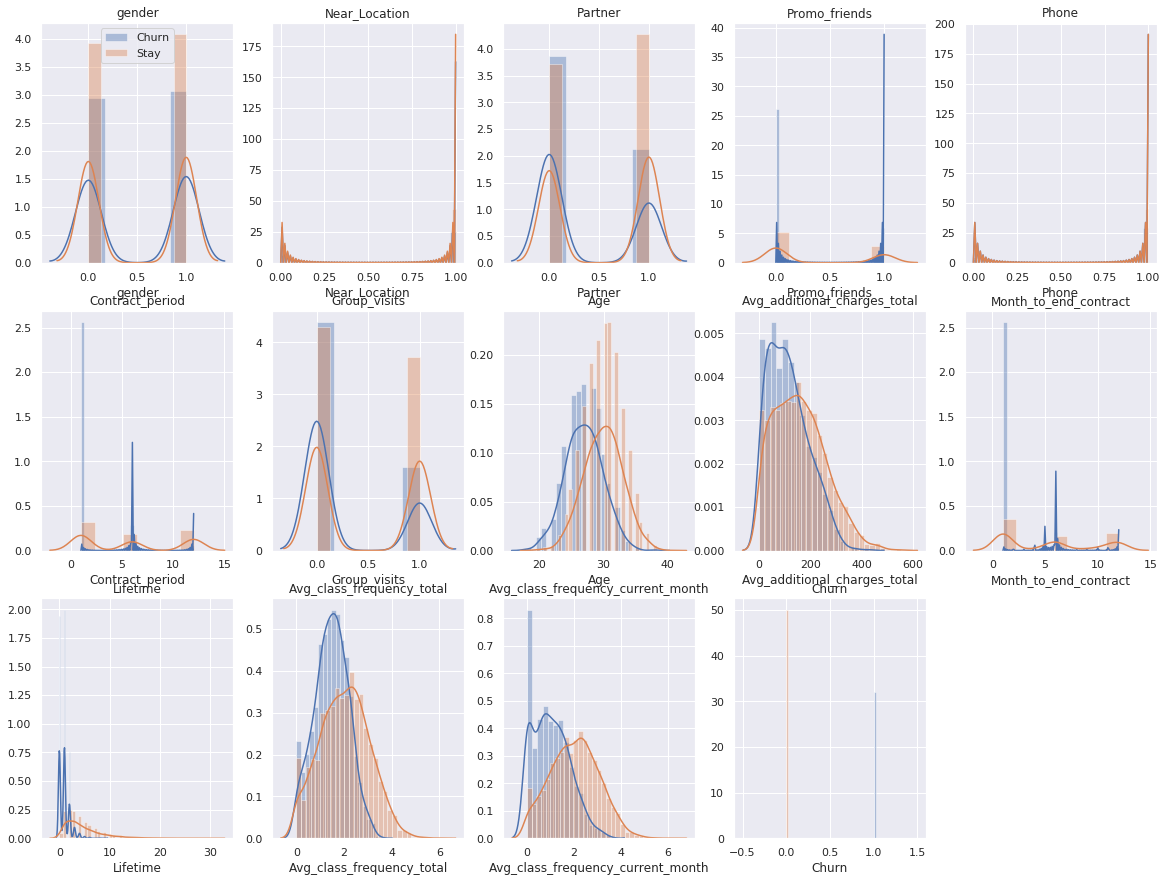

In [6]:
# Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (Churn) и тех, кто остался (Stay)
plt.subplots(figsize=(20, 15))
num_cols=5
num_rows=len(df.columns.values)//num_cols+1
for i, col in enumerate(df.columns.values):
    sns.distplot(df.query('Churn==1')[col], label='Churn', ax=plt.subplot(num_rows, num_cols, i+1))
    sns.distplot(df.query('Churn==0')[col], label='Stay')
    plt.title(col)
    if i==0: plt.legend()

<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

И отображение графиков тоже достаточно удобное, сам так постоянно делаю 😊
</div>

In [7]:
cm = df.corr() #вычисляем матрицу корреляций

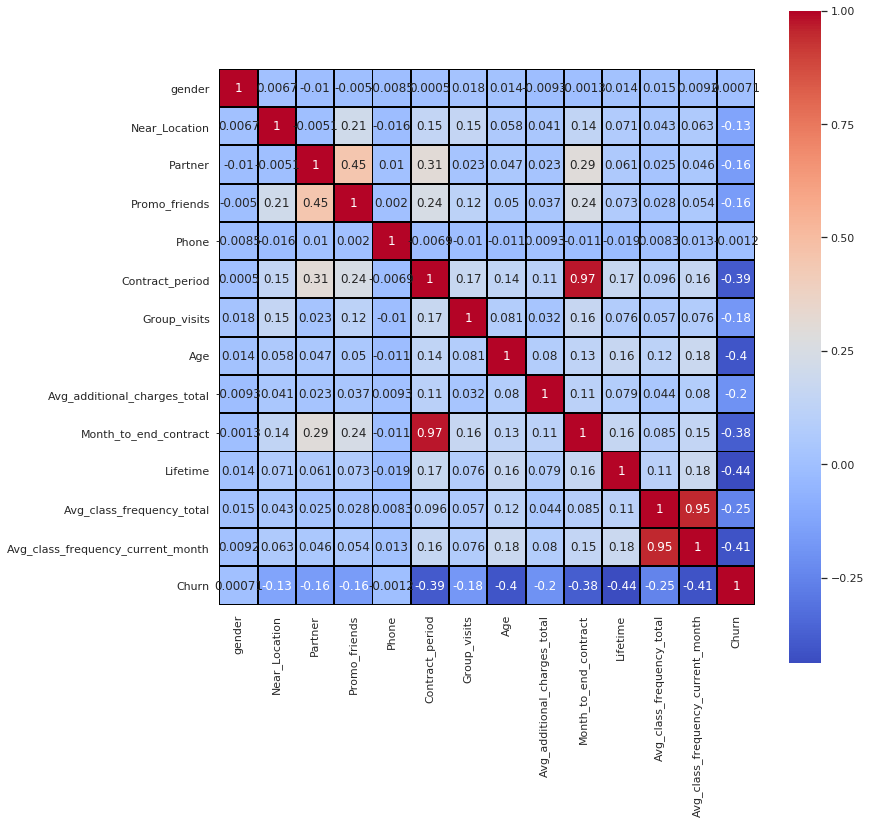

In [8]:
# нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, square=True, cmap= 'coolwarm', linewidths=1, linecolor='black') 
plt.show()

### Вывод: 
Полученные данные фактически готовы к модели, пропусков и категориальных переменных нет или они переведены в вид 0/1. Однако на основании графиков мы видим, что присутствуют незначительные выбросы и есть признаки, которые сильно коррелируют между собой. Такая сильная корреляция называется мультиколлинеарность, от нее нужно избавляться. Но конкретно в этом проекте можно не убирать.

## Шаг 3. Модель прогнозирования оттока клиентов <a class="anchor" id="chapter4"></a>

Итак построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

In [9]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:')
df['Churn'].value_counts()
#display(df.stb.freq(['Churn']))

Соотношение классов:


0    2939
1    1061
Name: Churn, dtype: int64

In [10]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
# обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = scaler.fit_transform(X_train) 
# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

# зададим алгоритм для нашей модели
model = LogisticRegression(random_state=0)
# обучим модель
model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
probabilities = model.predict_proba(X_test_st)[:,1]

# бинарный прогноз
predictions = model.predict(X_test_st)
# выведите все необходимые метрики для полученного прогноза
print('Метрики для логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))    # Accuracy
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))  # Precision
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))        # Recall
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))                # F1
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, probabilities)))    # ROC_AUC

Метрики для логистической регрессии
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
F1: 0.84
ROC_AUC: 0.97


Так как precision и recall направлены на избежание противоположных рисков, нужна сводная метрика, учитывающая баланс между метриками. Это F1-score. Дополнительно выведем метрику roc_auc или площадь под кривой ошибок AUC-ROC, для оценки качества классификатора.

Получили результаты работы Логистической регрессии, метрики точность (precision), полнота (recall) и количество правильных ответов (accuracy) показали очень неплохой результат. Теперь проверим как отработает RandomForest.


In [11]:
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train_st, y_train)
tree_predictions = tree_model.predict(X_test_st)
tree_probabilities = tree_model.predict_proba(X_test_st)[:,1]

print('Метрики для дерева принятия решения')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, tree_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, tree_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, tree_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, tree_predictions)))
print('ROC_AUC: {:.2f}'.format(roc_auc_score(y_test, tree_probabilities)))

Метрики для дерева принятия решения
Accuracy: 0.90
Precision: 0.79
Recall: 0.80
F1: 0.80
ROC_AUC: 0.87


Несмотря на то, что дерево более интерпретируемая модель, для нашей задачи оно оказалось слабее (по крайней мере на параметрах по умолчанию), чем логистическая регрессия.

## Шаг 4. Кластеризация клиентов, алгоритм K-Means <a class="anchor" id="chapter5"></a>

В бизнесе важно уметь применять обучение без учителя — когда правильных ответов для обучения модели нет. \
В целом задачи обучения без учителя сводятся к вычислению схожести между объектами. Когда модель её обнаружила, можно группировать сами объекты — решать задачу кластеризации. Можно вычислять и схожесть признаков — это потребуется для решения задачи снижения размерности.
Подробно разберём задачу кластеризации — она чаще всего встречается в бизнесе. Например, кластеризацию применяют:
 1. Для сегментации клиентов
 2. Для сегментации продуктов
 3. Для тематического моделирования

In [12]:
# еще раз стандартизируем данные 
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [13]:
# передадим получившуюся стандартизированную таблицу в качестве параметра функции linkage()
linked = linkage(X_sc, method='ward')

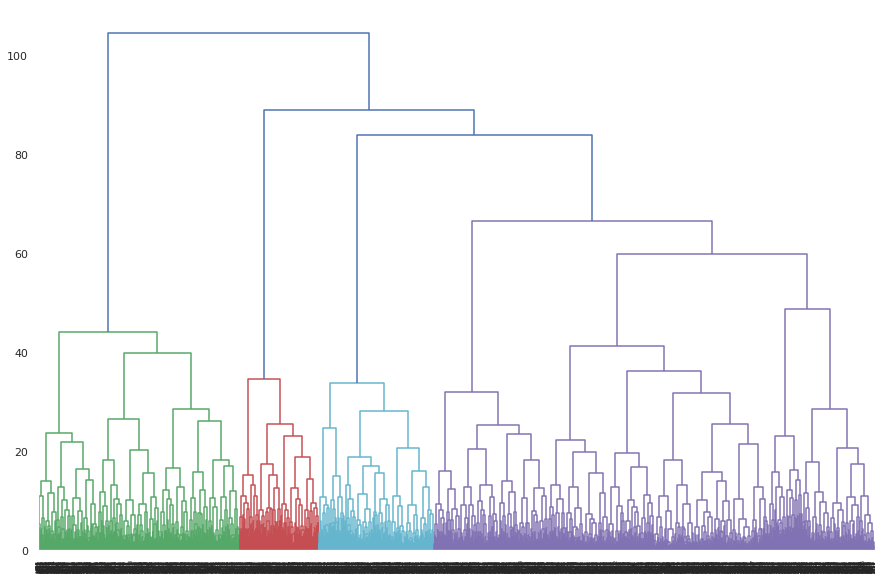

In [14]:
# в переменной linked сохранена таблица "связок" между объектами, визуализируем ее как дендрограмму
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.show()

На основании полученного графика предположим, что можно выделить 4 кластера (четыре разных цвета на графике). Хотя фиолетовый кластер получился довольно объемным, можно было бы разделить его на два.\
Теперь обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.

In [15]:
# задаем модель с числом кластеров 5
km = KMeans(n_clusters=5)
# прогнозируем кластеры для наблюдений (алгоритм присвоит номера от 0 до 4)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера
df['cluster'] = labels

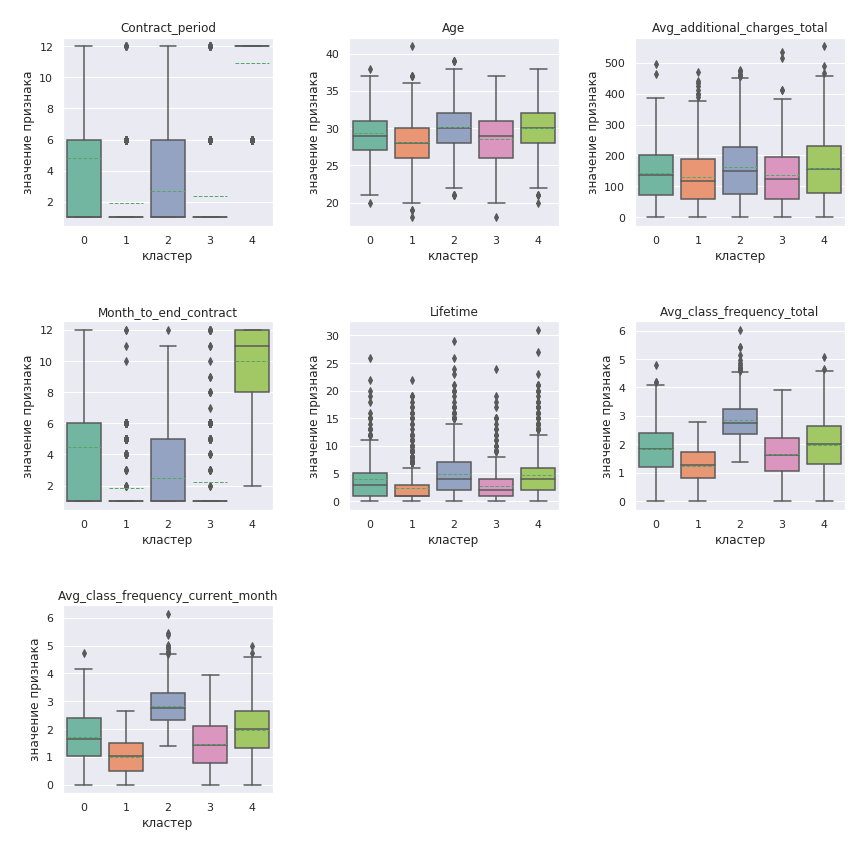

In [16]:
plt.subplots(figsize = (12, 12))
num_cols = 3
num_rows = 3

for i, col in enumerate(['Contract_period',
                         'Age',
                         'Avg_additional_charges_total',
                         'Month_to_end_contract', 'Lifetime',
                         'Avg_class_frequency_total',
                         'Avg_class_frequency_current_month']): # только числовые признаки
    sns.boxplot(x = 'cluster',
                y = df[col],
                data = df,
                ax = plt.subplot(num_rows, num_cols, i+1),
                meanline = True,
                showmeans = True,
                palette = 'Set2')
                #showfliers = False) # можно скрыть выбросы
   
    plt.title('\n' + col)
    plt.xlabel('кластер' + '\n')
    plt.ylabel('\n' + 'значение признака')
    plt.tight_layout()

Посмотрим на средние значения признаков для кластеров. И для каждого полученного кластера посчитаем долю оттока методом groupby(). Посмотрим какие кластеры склонны к оттоку, а какие — надёжны.

In [17]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.522078,0.484512,0.560142,0.495050,0.503490
Near_Location,0.862338,1.000000,0.976415,0.000000,0.959123
Partner,0.470130,0.351072,0.359670,0.463366,0.782652
Promo_friends,0.306494,0.237490,0.238208,0.079208,0.573280
Phone,0.000000,1.000000,0.998821,1.000000,1.000000
Contract_period,4.787013,1.954726,2.685142,2.352475,10.923230
Group_visits,0.425974,0.341541,0.469340,0.215842,0.546361
Age,29.301299,28.165210,30.110849,28.477228,29.991027
Avg_additional_charges_total,143.957664,131.444212,161.665710,135.457501,160.881742
Month_to_end_contract,4.475325,1.862589,2.476415,2.198020,9.983051


### Вывод
Из полученных данных мы наглядно видим, как минимум один кластер склонен к оттоку, другие два относительно надежны, и последние два надежны. Глядя на средние значения признаков можно ориентировочно охарактеризовать потенциального "отточника" так:
1. Avg_class_frequency_total и Avg_class_frequency_current_month показывают, что он не часто посещает зал;
2. Group_visits не увлекается групповыми занятиями;
3. Promo_friends купил абонемент без промо, значит занимается без друга-наставника; 
4. Partner не работает в организации-партнере фитнес клуба, то есть платит полную цену за абонемент;
5. Contract_period и Month_to_end_contract говорят нам, что абонемент скоро закончится;
6. Lifetime клиент обратился в фитнес клуб относительно недавно. 

## Шаг 5. Выводы и базовые рекомендации по работе с клиентами <a class="anchor" id="chapter6"></a>

Итак, мы научились прогнозировать вероятность оттока на уровне следующего месяца для каждого клиента. Метрики модели логистической регрессии оказались немного лучше, чем дерево принятия решения.

Провели кластеризацию клиентов. Описали кластер, который сильней всего склонен к оттоку. Дали портрет клиента из такого кластера с указанием признаков, которые сильней всего влияют на отток. 

Как правило, посетители спортзалов бросают благое начинание по трем причинам: стало скучно, посчитали нецелесообразным в финансовом плане ('Да я лучше дома позанимаюсь и на улице побегаю'), потеря мотивации. Сформулируем рекомендации для стратегии взаимодействия с клиентами и их удержания. 
- Для начала надо проверить групповые занятия, а точнее их разнообразие. Возможно к зумбе и пилатесу стоит добавить игровые виды спорта, ведь у них очень сильная вовлеченность
- Ввести специальные условия по продлению абонементов, если клиент покупает его за полную цену, так называемая скидка за "стаж"
- Предлагать бесплатные вводные тренировки с лучшими тренерами, которые смогут и поддержать разговор с клиентом и поднимут мотивацию к занятиям